In [27]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
Home = str(Path.home())

import numpy as np
import pandas as pd

import re

import sys
path = f'{Home}/repos/EPObjects/'
sys.path.insert(0, path)

from probabilistic.parameter import ProbabilisticParameters
from probabilistic.energy_predictions import EnergyPrediction, ProbabilisticEnergyPrediction
from ml_models import get_scaling_layer
from helper.run_period_helper import get_run_periods
from service import db_functions as db

In [28]:
solid_colors = ['#1f77b4', '#d62728', '#9467bd', '#2ca02c', '#ff7f0e',]
num_solid_colors = len(solid_colors)

def rgb_to_hex(c):
    c = c.astype(np.int16)
    return '#%02x%02x%02x' %(c[0], c[1], c[2])

def hex_to_rg(h):
    return np.array([int(h[i:i+2], base=16) for i in (1, 3, 5)], dtype=np.int16)

def get_weighed_color(col1, col2='#ffffff', w=0.5):
    c1 = hex_to_rg(col1)
    c2 = hex_to_rg(col2)
    return rgb_to_hex((c1 * (1-w)) + (w * c2))

class ColorScale:
    def __init__(self, c1, c2, mi, ma):
        self.Color1 = c1
        self.Color2 = c2
        self.Min = mi
        self.Max = ma
        self.Range = self.Max - self.Min

    def scale(self, value):
        return (value-self.Min)/self.Range
        
    def color(self, value):
        if isinstance(value, np.ndarray):
            vs = []
            for v in value:
                vs.append(get_weighed_color(self.Color1, self.Color2, self.scale(v)))
            return vs
        return get_weighed_color(self.Color1, self.Color2, self.scale(value))

In [29]:
user_name = 'tum-gni'
proj_name = 'tausendpfund-gn'
name = f'{user_name}_{proj_name}'
search_conditions = db.get_search_conditions(user_name, proj_name)
pps = ProbabilisticParameters.from_df(db.get_columns(search_conditions, db.PARAMETERS, convert_to_df=True))
scaling_df_x = pps.get_scaling_df()
_, targets = get_run_periods(db.get_columns(search_conditions, db.CONSUMPTION, convert_to_df=True))
targets = targets.mean(axis=1)
simulation_results = ProbabilisticEnergyPrediction.from_json(db.get_columns(search_conditions, db.SIMULATION_RESULTS,))
simulation_results = simulation_results.Values['Total']

mapping = {
    "u-value:WallExternal": "u-value",
    "Permeability": "Peremability",
    "HeatingSP": "Heating SP",
    "LightHeatGain": "Light Heat Gain",
    "HeatingCOP": "Heating COP",
}

def get_name_mapping(name):
    return mapping.get(name, '-')


In [39]:
results = db.get_columns(search_conditions, db.RESULTS,)
combinations = pd.DataFrame.from_dict(results[db.PARAMETERS])[:1]
predictions = pd.DataFrame.from_dict(results[db.PREDICTIONS])[:1]

scaling_data = db.get_columns(search_conditions, db.SCALING)
# scaling_df_x = pd.DataFrame.from_dict(scaling_data[db.SCALING_DF_X])
scaling_df_y = pd.DataFrame.from_dict(scaling_data[db.SCALING_DF_Y])

scaling_x = get_scaling_layer(scaled_df=scaling_df_x)
scaling_y = get_scaling_layer(scaled_df=scaling_df_y)

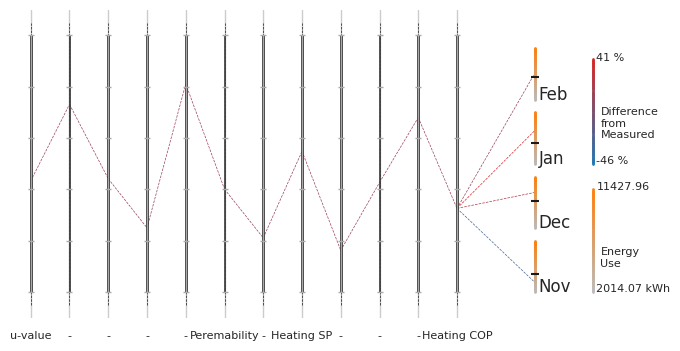

In [40]:
fig, ax = plt.subplots(figsize=(0.5 * len(scaling_df_x) + 2, 4), nrows = 1, ncols = 1)

th = 1.0
for i, pp in enumerate(pps):
    ax.plot([i, i], [-.05, 1.05], lw=0.5, ls='--', color='k', zorder=1)
    ax.bar([i, i], [0, 1], width=0.05, ec='k', lw=0.5, zorder=2, color='#aaaaaa')
    plt.plot(i * np.ones((6)), np.linspace(0, 1, 6), marker='_', markersize=5, color='#aaaaaa', lw=0.1)
    
    # plt.text(i, -0.05, f'{pp.Min:.02f}', size=8)
    # plt.text(i, 1.01, f'{pp.Max:.02f}', size=8)
    
    try: plt.scatter(i, scaled_x[i], 150, marker='_', color='k', zorder=100)
    except: pass

x = scaling_x(combinations).numpy()
y = scaling_y(predictions).numpy()*0.2
errors = pd.DataFrame.from_dict(results[db.ERRORS]).values
total_error = list(results[db.TOTAL_ERROR].values())

error_scale = ColorScale('#1f77b4', '#d62728', min(errors.min(), min(total_error)), max(errors.max(), max(total_error)))

previous = None


for i, chr in enumerate(x):
    for p, x1 in enumerate(chr):
        if previous is not None:
            plt.plot([previous[0], p], [previous[1], x1], lw=0.5, ls='--', color=error_scale.color(total_error[i]), zorder=-1)
        previous = [p, x1]
    
    for j, t in enumerate(y[i]):
        plt.plot([previous[0], p+2], [previous[1], j*0.25 + t], lw=0.5, ls='--', color=error_scale.color(errors[i, j]), zorder=-1)
        
    previous = None

results_pos = p+2
consumption_scale = ColorScale('#bbbbbb', '#ff7f0e', 0, 1.0)
breaks = 50
for i, t in enumerate(scaling_df_y.iterrows()):
    plt.text(results_pos+0.1, i*.25, t[0][:3], horizontalalignment='left')
    for j in range(breaks):
        ax.plot([results_pos, results_pos], [i*0.25 + j*0.2/breaks, i*0.25 + (j+1) * 0.2/breaks], lw=2, ls='-', color=consumption_scale.color(j/breaks), zorder=1)
        if i==0:
            ax.plot([results_pos+1.5, results_pos+1.5], [i*0.25 + j*0.4/breaks, i*0.25 + (j+1) * 0.4/breaks], lw=2, ls='-', color=consumption_scale.color(j/breaks), zorder=1)
    
ax.text(results_pos+1.6, 0, f'{scaling_df_y["Min"][0]:.02f} kWh', size=8)
ax.text(results_pos+1.7, 0.1, f'Energy\nUse', size=8)
ax.text(results_pos+1.6, 0.4, f'{scaling_df_y["Max"][0]:.02f}', size=8)

increment = error_scale.Range/breaks
for j in np.linspace(error_scale.Min, error_scale.Max, breaks):
    y_start = 0.5 + error_scale.scale(j) * 0.4 
    y_end = 0.5 + error_scale.scale(j+increment) * 0.4
    ax.plot([results_pos+1.5, results_pos+1.5], [y_start, y_end], lw=2, ls='-', color=error_scale.color(j), zorder=1)
    # break

ax.text(results_pos+1.6, 0.5, f'{error_scale.Min:0.0f} %', size=8)
ax.text(results_pos+1.7, 0.6, f'Difference\nfrom\nMeasured', size=8)
ax.text(results_pos+1.6, 0.9, f'{error_scale.Max:0.0f} %', size=8)

res = scaling_y(targets).numpy() * 0.2
for i, t in enumerate(res):
    ax.scatter(results_pos, i*0.25 + t, marker='_', color='k')

xticks = tuple(get_name_mapping(x) for x in pps.get_names())
ax.set_xticks(range(len(xticks)), labels=xticks, size=8, rotation=0, horizontalalignment='center', verticalalignment='top')
ax.set_yticks([])
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-.5, results_pos+2.5])

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.savefig(f'{name}-parameters.pdf', bbox_inches='tight')

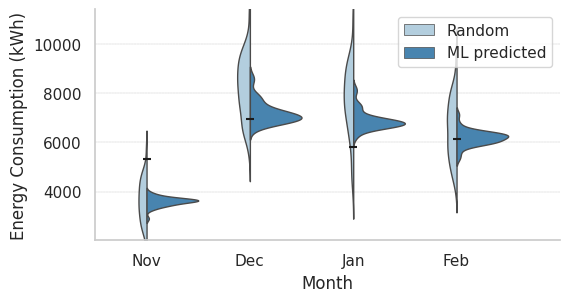

In [32]:
#half violin plots using seaborn graph
#upper values: parameter estimation (in results: simulationdata.values)
#lower values: combinations, last columns
#y1, y2 from Targets (measured values)
import seaborn as sns
sns.set(rc={'figure.figsize':(6,3)})
sns.set_theme(style="whitegrid")

data = pd.DataFrame()
for x, month in enumerate(simulation_results):
  plt.vlines(x, 2.5, 9.5, lw=0.5, color="grey", linestyle = '-.', zorder=-1) 
  
  d1 = pd.DataFrame()
  d1['Energy'] = simulation_results[month]
  d1['Approach'] = 'Random'
  d1['Month'] = month

  d2= pd.DataFrame()
  d2['Energy'] = predictions[month]
  d2['Approach'] = 'ML predicted'
  d2['Month'] = month

  data = pd.concat((data, d1, d2))

ax=sns.violinplot(data=data, width=1, x="Month", y="Energy", hue="Approach", split=True, inner=None, linewidth=1, palette="Blues")

for i, value in enumerate(targets):
    plt.scatter(i, value, marker='_', color='k')
    # plt.text(i, value[x], f' {z}', verticalalignment='center')

plt.xticks(range(len(targets)), [x[:3] for x in scaling_df_y.index])

plt.ylabel('Energy Consumption (kWh)')
plt.xlim(-0.5, len(targets))
plt.ylim(simulation_results.values.min(), simulation_results.values.max())
plt.grid(axis='y', color='k', linestyle='--', linewidth=0.1)

ax.spines[['right', 'top',]].set_visible(False)
ax.legend(loc = None)#"lower right")
plt.savefig(f'{name}-predictions.pdf', bbox_inches='tight')
plt.show()


In [33]:
targets

0    5322.0
1    6972.0
2    5795.0
3    6123.5
dtype: float64

In [34]:
# from scipy.stats import norm
# from math import sqrt
# from scipy.stats import t

# import numpy as np
# from numpy.random import seed
# from numpy.random import rand
# from numpy.random import randint
# from numpy import mean
# from numpy import median, mean

# from numpy import percentile

# def ConfidenceIntervalWithoutBS(y):
#     alpha = 5.0
#     lower_p = alpha / 2.0
#     lower = percentile(y, lower_p)
#     upper_p = (100 - alpha) + (alpha / 2.0)
#     upper = percentile(y, upper_p)
#     print (f'{lower:0.02f}-{upper:0.02f}')
#     return lower, upper

# def ConfidenceInterval(y, n=50):
#     seed(1)
#     scores = list()
#     dataset = y
#     samples = len(dataset)
#     for _ in range(n):
#         indices = randint(0, samples, samples)
#         sample = dataset[indices]
#         # calculate and store statistic
#         statistic = sqrt(mean(sample))
#         scores.append(statistic)
    
#     m = mean(scores)
    
#     alpha = 5.0
#     lower_p = alpha / 2.0
#     lower = percentile(scores, lower_p)
#     upper_p = (100 - alpha) + (alpha / 2.0)
#     upper = percentile(scores, upper_p)

#     print (f'{lower:0.02f}-{upper:0.02f}')
#     return lower, upper

In [35]:
# for x, month in enumerate(results):
#   print (month)
#   ConfidenceIntervalWithoutBS(Combinations[f'Predicted_{x}'])
#   ConfidenceIntervalWithoutBS(results[month])

In [36]:
res = scaling_y(targets).numpy() * 0.2

In [37]:
res

array([0.07027759, 0.10533219, 0.08032658, 0.08730563], dtype=float32)